# Caractérisation de l'overfitting de différents modèles linéaires dans le cadre d'un modèle sans signaux

Dans ce notebook, à partir d'une certaine matrice de rendements, nous allons utiliser différents modèles linéaires afin de construire des portefeuilles les plus efficaces possible. 

- Les portefeuilles sont, en fait, des vecteurs dont les composantes sont la pondération de chacun des actifs dans notre investissement. 
- L'efficacité du portefeuille est mesurée à partir de la donnée du Sharpe Ratio (rendement / écart-type)
- La quantification de l'overfitting sera calculée à partir de la performance relative du portefeuille out-sample par rapport à sa performance in-sample. On utilisera aussi le rapport de la fonction de loss quadratique du modèle out-sample sur celle in-sample. 

In [1]:
#Import des packages utiles 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Import des fonctions "outils"
from Test_ToolsFunctions import rdt_matrix_generator
from Test_ToolsFunctions import pred_sharpe
from Test_ToolsFunctions import perf_model_plot
from Test_ToolsFunctions import test_linear_model

#Import des modèles linéaires
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV #Cross-validation intégrée
from sklearn.linear_model import RidgeCV #Cross-validation intégrée
from sklearn.linear_model import Lasso
from sklearn.linear_model import Lars

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


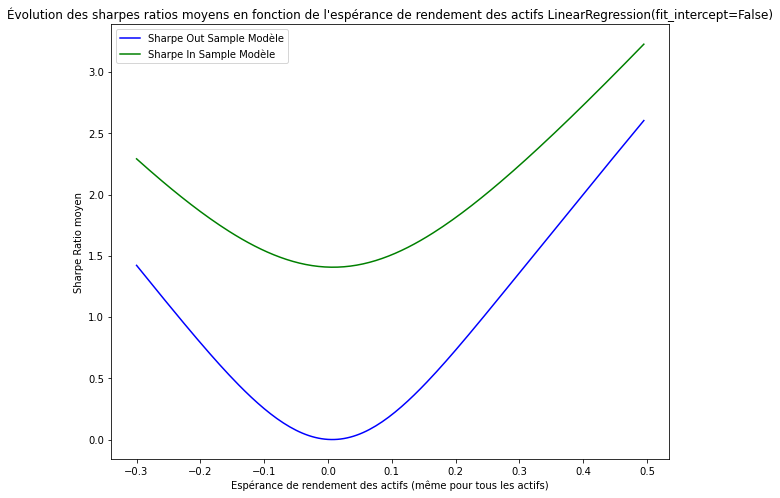

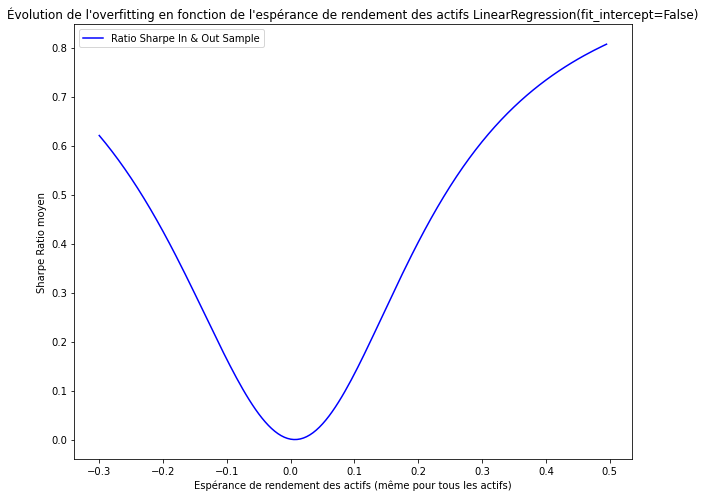

In [2]:
test_linear_model(5,0.5, LinearRegression(fit_intercept = False))

[1.606879740197851, 1.5666841030306329, 1.5355009894652418, 1.510852964455943, 1.4910513822014515, 1.4749152753603476, 1.4615998966531836, 1.450488821554708, 1.4411241639784202, 1.4331603317790074, 1.4263327074062508, 1.4204360164555885, 1.4153091192647127, 1.410824143682374, 1.4068786038862757, 1.4033896064472673, 1.4002895371275557, 1.3975228125846622, 1.3950434076700389, 1.3928129542766343, 1.3907992659935173, 1.3889751832353077, 1.387317661876635, 1.3858070485646201, 1.3844265003463987, 1.383161516743104, 1.3819995600906438, 1.380929745652915, 1.3799425872536022, 1.3790297873615331, 1.3781840629812565, 1.3773990005454901, 1.3766689344245622, 1.3759888447656745, 1.3753542712297877, 1.3747612398637632, 1.3742062008732545, 1.3736859754800945, 1.3731977103810387, 1.3727388385914072, 1.3723070456716517, 1.3719002405081926, 1.3715165299605434, 1.3711541968013945, 1.3708116804701305, 1.3704875602373785, 1.370180540441711, 1.369889437512274, 1.3696131685347905, 1.3693507411547945, 1.369101

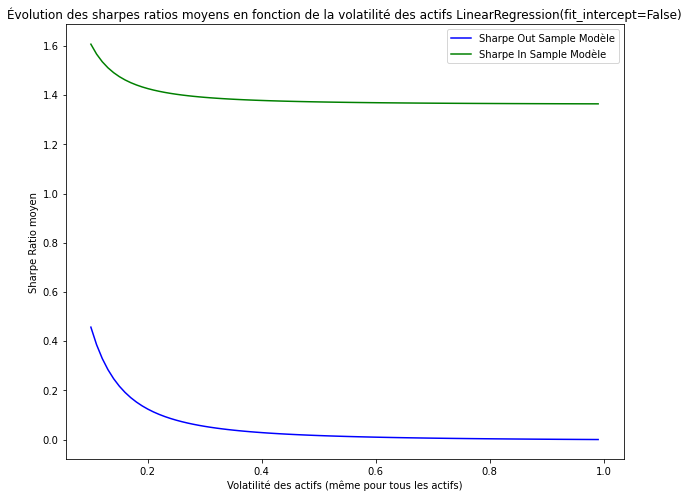

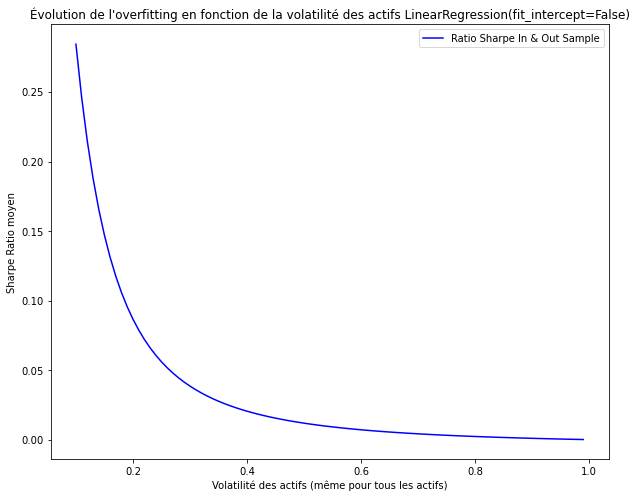

In [3]:
test_linear_model(4,1, LinearRegression(fit_intercept = False))

Désormais, nous allons nous placer dans le cas 1) où tous les actifs suivent la même loi. Nous allons tester et afficher le graphique de l'évolution des sharpes ratios in et out sample en fonction de la variation de tous ces paramètres. 
Nous afficherons l'évolution de la fonction de perte quadratique in & out sample. 

Les paramètres qui varieront : 
- Nombre d'actifs
- Nombre de dates dans l'échantillon d'entraînement
- Espérance des rendements (constante pour tous)
- Variance des rendements (constante)
- Corrélation entre les actifs
- Ratio Nombre de lignes / Nombre de colonnes dans la matrice des rendements (combinaison du nombre d'actifs et du nombre de dates de train)
- Nombre de blocs d'actifs aux lois différentes

## Méthodologie

Désormais, nous allons utiliser une nouvelle approche afin de limiter le temps de calcul. A chaque pas, c'est-à-dire à chaque fois que l'on fait varier un paramètre du problème et que l'on fit un nouveau modèle, nous procédons de la sorte : 

- 1) Par Cross-Validation, on va tuner le paramètre du modèle en question (par exemple la valeur de la pénalisation) afin qu'il soit le moins overfitté possible. Ainsi, on pourra comparer les performances optimales out-sample de chacun des modèles. Parfois cette tâche pourra être facilitée par les modèles fournis par Sklearn qui peuvent être capable de choisir directement le paramètre optimal du modèle (Ex: LassoCV ou RidgeCV)
- 2) De la même façon que pour une K-fold Cross-Validation, on génère K matrices de rendements correspondant aux nouveaux paramètres et l'on y fit K modèles avec la méthode testée. 

Remarque : Dans un but de simplification computationnelle, dès la 1ère itération, on va fixer les vecteurs d'aléas relatifs à notre matrice de rendements. C'est-à-dire qu'il suffira à chaque itération de réutiliser ces K vecteurs gardés en mémoire pour éviter d'avoir à les regénérer et avoir une courbe finale plus lisse. (On considère que le temps d'exécution de la génération des matrices aléatoires est grandement expliqué par cette étape mais à vérifier). Par exemple, si le paramètre qui varie est l'espérance ou la matrice variance-covariance de notre vecteur aléatoire, on garde le vecteur d'aléa initial et quelques variations dans le code seront suffisante pour générer le nouveau vecteur adéquat. Enfin, lorsque l'on souhaitera faire varier la taille de cette matrice de rendements, on génèrera des matrices de taille maximales et à chaque itération on utilisera la sous-matrice qui nous intéresse (la grande matrice qui se découvre petit à petit est ce un problème -> introduction de biais dans le modèle au sens ou la première ligne/colonne sera toujours utilisée)

- 3) Ensuite, il suffira de tester chacun des K modèles sur les (K-1) datasets sur lesquels il n'a pas été entraîné (-> gain computationnel de ne pas générer de nouveaux datasets de tests + constat suivant : faire 1000 simus de tests de 1 an puis la moyenne des sharpes équivalent à regarde le sharpe moyen sur un échantillon test de 1000 ans ? Si non, est ce que cette approche reste quand même valide ? Si oui, on obtient le même résultat que l'approche précédent avec les datatests de 1an & si non, pas grave on aura des échantillons de tests qui seront de même taille que le train ou alors on split chacun des K-1 en datasets de taille 1 an). Ainsi, on obtient la moyenne de la performance out-sample de chaque modèles et on le re-moyennise afin de tracer la courbe de la performance MOYENNE du type de modèle testé.   

- 4) On obtient alors un graphe montrant l'évolution de la performance moyenne in & out sample du type de modèle testé selon la variation du paramètre d'intérêt. On finir par tracer l'évolution du rapport Sharpe Out sur Sharpe In dont on pense qu'il donne la tendance de l'overfitting et de plus, la valeur intrinsèque de ce rapport nous intéresse car elle indique de "combien" baisse le sharpe en passant du IN au OUT (vérifier si on a aucun biais concernant cette valeur absolue et qu'elle est bien comparable entre les modèles). 

- 5) A chaque étape garder trace de la quadratic loss in & out sample et la comparer aussi ???? 

## Variation du nombre d'actifs

Ici, nous allons faire varier le nombre de colonnes de la matrice (nb d'actifs). 
Pour ce qui est de loi des actifs on garde celle de l'exemple initial -> à savoir tous suivent la même loi. 
On va entraîner chacun des modèles sur 10 ans d'historique

Seulement dans un second temps, on testera avec des vecteurs d'actifs qui ont des lois différentes (pas fait encore)

#### Régression Simple (Benchmark)

Ici, pas de paramètre à tuner donc on passe directement à l'étape 2. 

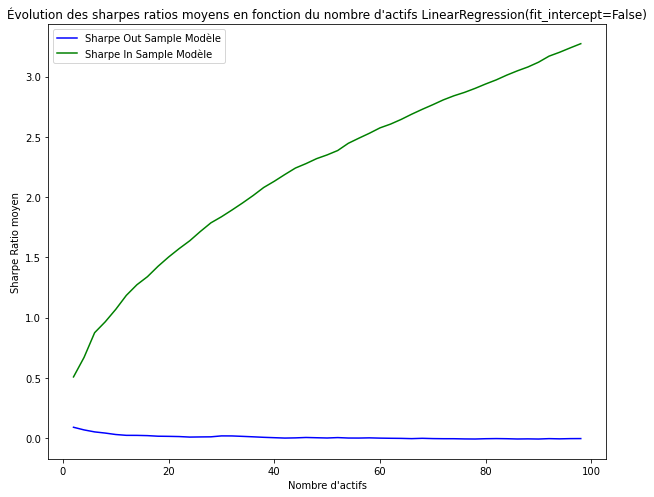

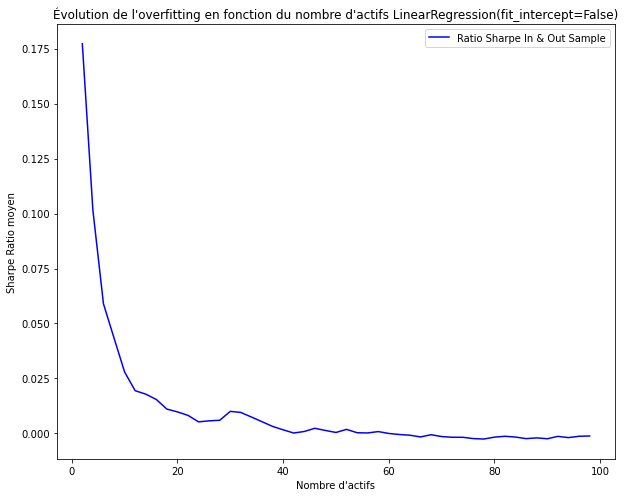

In [4]:
test_linear_model(1,100, LinearRegression(fit_intercept = False))

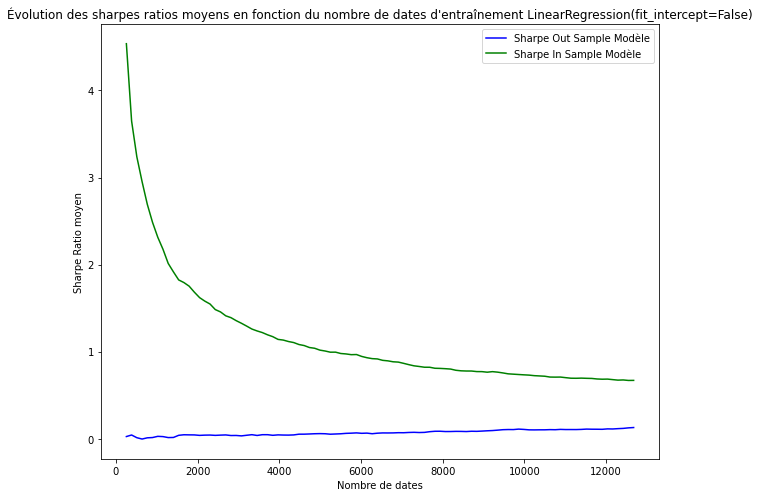

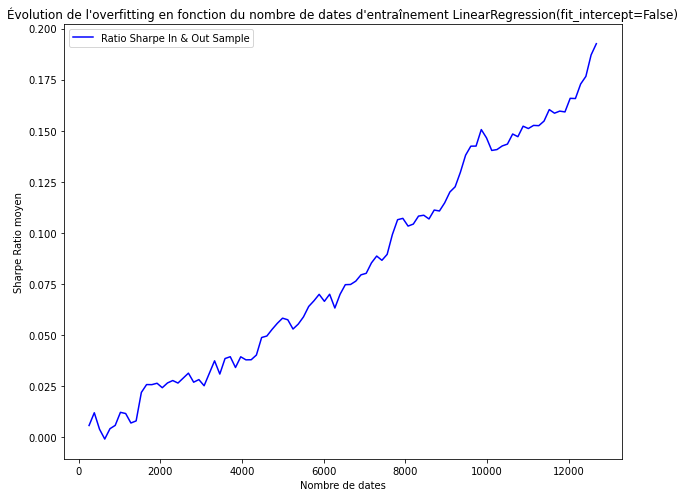

In [5]:
test_linear_model(2,256*50, LinearRegression(fit_intercept = False))

Problématiques : 

- On ne peut pas mettre des correls négatives entre les assets sinon la matrice de Covar n'est pas définie positive...